In [1]:
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore

from open_ephys.analysis import Session
from pathlib import Path
import glob

import spikeinterface as si
import xarray as xr
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from aind_ephys_utils import align 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.lick_analysis import load_nwb, load_data
from hdmf_zarr.nwb import NWBZarrIO
from beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF
from ephys_functions import build_time_window_domain, \
                            build_spike_histogram, \
                            build_spike_histogram_overlap, \
                            fitSpikeModelP, \
                            fitSpikeModelG

%matplotlib inline
%matplotlib widget

### Load behavior and model data

In [77]:
session_id = 'behavior_717121_2024-06-15_10-00-58'
model_name = 'stan_qLearning_5params'

In [78]:
session_dir = session_dirs(session_id, model_name)
nwb = load_nwb(session_dir['nwb_dir'])
model_dv, session_cut = load_model_dv(session_id, model_name)
trial_df = makeSessionDF(nwb, cut=session_cut)
session_df = pd.merge(trial_df, model_dv, left_index=True, right_index=True, suffixes=('', '_model'))
for column in session_df.columns:
    if '_model' in column:
        session_df.drop(column, axis=1, inplace=True)
session_df.head()

if 'Q_r' in session_df.columns:
    Qchosen = session_df['Q_l'].values
    Qchosen[np.where(session_df['choice']>0)] = session_df.loc[session_df['choice']>0, 'Q_r']
    session_df['Qchosen'] = Qchosen

AttributeError: 'NoneType' object has no attribute 'to_dataframe'

In [81]:
nwb = load_nwb(session_dir['nwb_dir'])

### Load neuron data, realign if needed

In [4]:
unit_spikes = nwb.units[:][['ks_unit_id', 'spike_times']]

In [5]:
unit_qc = nwb.units[:][['ks_unit_id', 'isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label']]
unit_wf = nwb.units[:][['ks_unit_id', 'waveform_mean', 'waveform_sd']]

In [6]:
# realign units if needed
if os.path.exists(os.path.join(session_dir['alignment_dir'], 'harp_times.npy')):
    harp_times = np.load(os.path.join(session_dir['alignment_dir'], 'harp_times.npy'))
    local_times = np.load(os.path.join(session_dir['alignment_dir'], 'local_times.npy'))
    print('Alignment files found, units will need to be realigned.')
    for unit_ind in range(len(unit_spikes)):
        unit_spikes.at[unit_ind, 'spike_times'] = align_timestamps_to_anchor_points(unit_spikes['spike_times'][unit_ind], local_times, harp_times)

Alignment files found, units will need to be realigned.


Check alignment of units with licks


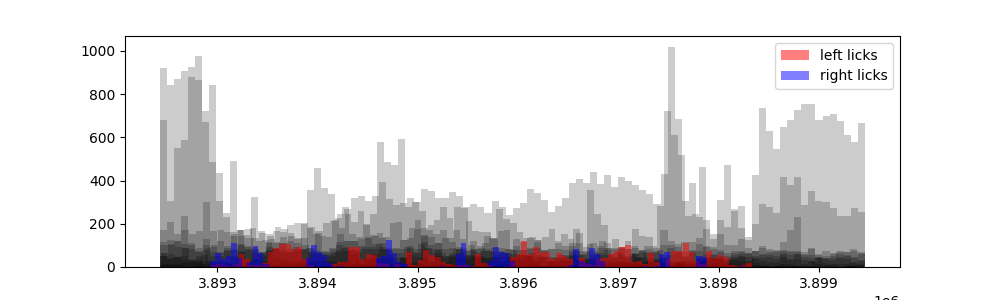

In [8]:
# Check realignment
data = load_data(nwb)
figure = plt.figure(figsize=(10, 3))
for unit_ind in range(0, len(unit_spikes), 20):
    plt.hist(unit_spikes['spike_times'][unit_ind], color='k', alpha=0.2, bins=100)
plt.hist(data['left_licks'], bins=100, color='r', alpha=0.5, label='left licks');
plt.hist(data['right_licks'], bins=100, color='b', alpha=0.5, label='right licks');
plt.legend()
print('Check alignment of units with licks')

### Infer major drift point of all units pass qc and cut session short

In [10]:
# start time and end time from start of recording: 
ephys_cut = [2500, 8000] + harp_times[0]
session_df_ephys = session_df[(session_df['go_cue_time'] > ephys_cut[0]) & (session_df['go_cue_time'] < ephys_cut[1])]
session_df_ephys.head()

,outcome,choice,laser,outcome_prev,laser_prev,choices_prev,go_cue_time,choice_time,outcome_time,Q_r,Q_l,pe,pChoice,Qchosen
188,0.0,0.0,0.0,1.0,0.0,0.0,3.894937e+06,3.894937e+06,3.894937e+06,0.002924,0.981401,-0.981401,0.988664,0.981401
189,0.0,0.0,0.0,0.0,0.0,0.0,3.894943e+06,3.894943e+06,3.894943e+06,0.001807,0.837870,-0.837870,0.981277,0.837870
190,0.0,0.0,0.0,0.0,0.0,0.0,3.894998e+06,3.894998e+06,3.894998e+06,0.001138,0.716784,-0.716784,0.970953,0.716784
191,0.0,0.0,0.0,0.0,0.0,0.0,3.895006e+06,3.895006e+06,3.895006e+06,0.000728,0.614424,-0.614424,0.957759,0.614424
192,0.0,0.0,0.0,0.0,0.0,0.0,3.895011e+06,3.895012e+06,3.895012e+06,0.000473,0.527719,-0.527719,0.942179,0.527719


### Plot all units pass qc

In [11]:
# to do: recompute qc with cut off sessions (code is ready in other capsule)
pass_qc = (unit_qc['isi_violations_ratio'] < 0.1) & \
          (unit_qc['firing_rate'] > 0.1) & \
          (unit_qc['presence_ratio'] > 0.95) & \
          (unit_qc['amplitude_cutoff'] < 0.05) & \
          (unit_qc['decoder_label'] != 'noise') & \
          (unit_qc['decoder_label'] != 'artifact')
pass_qc = pass_qc.values
print(f'{np.sum(pass_qc)} out of {len(pass_qc)} units pass qc')

50 out of 281 units pass qc


In [12]:
# # responseInds
# responseInds = tblTrials['animal_response']!=2

# response time
trialStarts = session_df_ephys['go_cue_time'].values
responseTimes = session_df_ephys['choice_time'].values

# outcome                                       
outcomes = session_df_ephys['outcome'].values == 1
outcomePrev = session_df_ephys['outcome_prev'].values == 1

# choices
choices = session_df_ephys['choice'].values == 1
choicesPrev = session_df_ephys['choices_prev'].values == 1
# laser

laserChoice = session_df_ephys['laser'].values
laserPrev = session_df_ephys['laser_prev'].values
trialData = session_df_ephys


# Alignment settings

In [59]:
align_name = 'response'
if align_name == 'go_cue':
    alignTime = session_df_ephys['go_cue_time'].values
elif align_name == 'response':
    alignTime = session_df_ephys['choice_time'].values

In [61]:
# make xarray for response alignment
binSize = 0.2 # in second
stepSize = 0.05 # in second
bin_edges = np.arange(-2, 3, stepSize)
time_domain_callback = None
timestamps = list(unit_spikes['spike_times'].values)

domain = build_time_window_domain(
    bin_edges,
    alignTime,
    callback=time_domain_callback)

time, counts = build_spike_histogram_overlap(
    domain,
    binSize,
    timestamps,
)

time = bin_edges[:-1] + 0.5*binSize
tiled_data = 1/binSize * counts

trialInds = np.array(range(len(alignTime)))

spike_toResponse = xr.DataArray(
    name='spike_counts',
    data=tiled_data,
    dims=['trialInd',
          'trialTime',
          'unit_id'],
    coords={
        'trialInd': trialInds,
        'trialTime': time,
        'unit_id': range(len(unit_spikes))
    }
)


# for LM
binSizeLM = 0.5
stepSizeLM = 0.2
bin_edgesLM = np.arange(-2, 3, stepSizeLM)

domain = build_time_window_domain(
    bin_edgesLM,
    alignTime,
    callback=time_domain_callback)
dtype = None

timeLM, countsLM = build_spike_histogram_overlap(
    domain,
    binSizeLM,
    timestamps,
)
timeLM = bin_edgesLM[:-1] + 0.5*binSizeLM
tiled_dataLM = 1/binSizeLM * countsLM

In [63]:
colors = ["blue", "white", "red"]
custom_cmap = LinearSegmentedColormap.from_list("blue_white_red", colors)

def plot_filled_sem(time, y_mat, color, ax, label):
    ax.plot(time, np.nanmean(y_mat, 0), c = color, label = label)
    sem = np.std(y_mat, axis = 0)/np.sqrt(np.shape(y_mat)[0])
    ax.fill_between(time, np.nanmean(y_mat, 0) - sem, np.nanmean(y_mat, 0) + sem, color = color, alpha = 0.25, edgecolor = None)

def plot_raster_rate(
    events,
    currArray, 
    align_events, # sorted by certain value
    map_value,
    bins,
    labels,
    colormap,
    fig,
    subplot_spec,
    tb=-5,
    tf=10,
    bin_size=100 / 1000,
    step_size=50 / 1000,
):
    n_colors = len(bins)-1
    color_list = [colormap(i / (n_colors - 1)) for i in range(n_colors)]

    """Plot raster and rate aligned to events"""
    nested_gs = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios= [3, 1], subplot_spec=subplot_spec)
    ax1 = fig.add_subplot(nested_gs[0, 0])
    ax2 = fig.add_subplot(nested_gs[1, 0])

    # order events by values
    sort_ind = np.argsort(map_value)
    align_events = align_events[sort_ind]

    df = align.to_events(events, align_events, (tb, tf), return_df=True)
    
    # vertical line at time 0
    ax1.axvline(x=0, c="r", ls="--", lw=1, zorder=1)

    # raster plot
    ax1.scatter(df.time, df.event_index, c="k", marker="|", s=1)

    # horizontal line for each type if discrete
    if len(np.unique(map_value)) <= 4:
        discrete_types = np.sort(np.unique(map_value))
    else:
        discrete_types = bins
    
    for val in discrete_types:
        level = np.sum(map_value <= val)
        ax1.axhline(y=level, c="k", ls="--", lw=1)

    ax1.set_title(' '.join(labels))
    ax1.set_xlim(tb, tf)
    ax1.set_ylabel('__'.join(labels))

    # rate plot by binned values

    for bin_ind in range(len(bins)-1): 
        currList = np.where((np.array(map_value)>=bins[bin_ind]) & (np.array(map_value)<bins[bin_ind + 1]))[0]
        M = currArray.sel(trialInd = currList).values
        plot_filled_sem(currArray.trialTime, M, color_list[bin_ind], ax2, labels[bin_ind])

    ax2.legend()

    ax2.set_title("spike rate")
    ax2.set_xlim(tb, tf)
    ax2.set_xlabel("Time from alignment (s)")

    return fig, ax1, ax2

In [70]:
def plot_unit_new(unitInd, unit_label, align_time, alignment, savepath):
    plt.clf()
    currArray = spike_toResponse.sel(unit_id = unitInd)
    currArrayLM = np.squeeze(tiled_dataLM[:,:,unitInd])
    # currArrayBl = spike_toResponseBl.sel(unit_id = unitInd)
    currSpikes = timestamps[unitInd]
    fig = plt.figure(figsize=(30, 15))
    gs = gridspec.GridSpec(2, 7, width_ratios=[1,1,1,1,1,1,1], height_ratios=[4, 1])

    # from start to end
    ax = fig.add_subplot(gs[0, 0])  
    df = align.to_events(currSpikes, align_time, (tb, tf), return_df=True)
    ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1)
    ax.set_xlim(tb, tf)
    ax.set_ylabel('Trial number', fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    plt.plot([0,0],[0,df.event_index.max()],'r')
    plt.suptitle(f'Unit{str(unit_label)} Aligned to {alignment}', fontsize = 20)

    # waveform
    ax = fig.add_subplot(gs[1, 0])  
    waveform = unit_wf['waveform_mean'][unitInd]
    peakChannel = np.argmin(np.min(waveform, axis=0))
    peakWaveform = waveform[:,peakChannel]
    peakSD = unit_wf['waveform_sd'][unitInd][:,peakChannel]
    timeWF = np.array(range(len(peakWaveform)))-90
    ax.plot(timeWF, peakWaveform, color = 'k')
    ax.fill_between(timeWF, peakWaveform - peakSD, peakWaveform + peakSD, color = 'k', alpha = 0.1)
    ax.axhline(y=0, color = 'r', ls = '--')
    ax.set_xlabel('Time (ms)', fontsize = fs)
    ax.set_ylabel(r'$\mu$-Plot')

    # reward and no reward
    outcome_int = [int(item) for item in outcomes]
    bins = [-1, 0.5, 1.5]
    labels = ['no reward', 'reward']
    plot_raster_rate(currSpikes,
                    currArray, 
                    align_time, 
                    outcome_int, # sorted by certain value
                    bins,
                    labels,
                    custom_cmap,
                    fig,
                    gs[:, 1],
                    tb=tb,
                    tf=tf,
                    bin_size=100 / 1000,
                    step_size=50 / 1000,
                    )

    # left and right
    side_int = [int(item) for item in choices]
    bins = [-1, 0.5, 1.5]
    labels = ['left', 'right']
    plot_raster_rate(currSpikes,
                    currArray, 
                    align_time, 
                    side_int, # sorted by certain value
                    bins,
                    labels,
                    custom_cmap,
                    fig,
                    gs[:, 2],
                    tb=tb,
                    tf=tf,
                    bin_size=100 / 1000,
                    step_size=50 / 1000,
                    )

    # rpe
    target_values = session_df_ephys['pe'].values
    bins = np.quantile(target_values, [0, 0.25, 0.5, 0.75, 1])
    # bins = [-1.0001, -0.5, 0, 0.5, 1.0001]
    labels = ['1', '2', '3', '4']
    plot_raster_rate(currSpikes,
                    currArray, 
                    align_time, 
                    target_values, # sorted by certain value
                    bins,
                    labels,
                    custom_cmap,
                    fig,
                    gs[:, 3],
                    tb=tb,
                    tf=tf,
                    bin_size=100 / 1000,
                    step_size=50 / 1000,
                    )
    
    ax.tick_params(axis='both', which='major', labelsize=fs)
    # ax.set_yticks([])
    ax.set_ylabel(label, fontsize = fs)
    gs = gridspec.GridSpec(3, 2, width_ratios=[3,2], height_ratios=[1, 1, 1])
    ax = fig.add_subplot(gs[1,1])
    
    # plot regresssions
    regressors, TvCurrU, PvCurrU, EvCurrU = fitSpikeModelP(trialData, currArrayLM, formula)
    TvCurrUSig = TvCurrU.copy()
    TvCurrUSig[PvCurrU>=0.05] = np.nan
    colors = cmap(np.linspace(0, 1, len(regressors)))
    for regress in range(1, len(regressors)):
        ax.plot(timeLM, TvCurrU[:, regress], lw = 1, color = colors[regress,], label = regressors[regress])
        ax.plot(timeLM, TvCurrUSig[:, regress], lw = 3, color = colors[regress,])
    ax.legend(fontsize = fsLegend)
    ax.set_xlabel(f'Time from {alignment} (s)', fontsize = fs)
    ax.set_title('T-stats', fontsize = fs)

    ax = fig.add_subplot(gs[0,1])
    for regress in range(1, len(regressors)):
        ax.plot(timeLM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])

    plt.axhline(y = -np.log10(0.05), color='r', ls = '--')
    ax.legend(fontsize = fsLegend)
    ax.set_xlabel(f'Time from {alignment} (s)', fontsize = fs)
    ax.set_title('p-value', fontsize = fs)
    # # baseline 
    # gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1,1], height_ratios=[1, 1, 1])
    # ax = fig.add_subplot(gs[2,3])
    # numBins = 3
    # rInd = np.argsort(trialData['Qr'])
    # M = []
    # for b in range(numBins):
    #     currM = currArrayBl.sel(trialInd = rInd[int(np.round(b*len(rInd)/numBins)): int(np.round((b+1)*len(rInd)/numBins))].values).mean(dim='trialInd')
    #     M.append(currM)

    # cmap = plt.get_cmap('coolwarm')
    # colors = cmap(np.linspace(0.6, 1, len(M)))
    # for b in range(numBins):
    #     ax.plot(timeBl, M[b].values, c = colors[b,:])

    # ax.set_title('Qr')

    # ax = fig.add_subplot(gs[2, 4])
    # numBins = 3
    # rInd = np.argsort(trialData['Ql'])
    # M = []
    # for b in range(numBins):
    #     currM = currArrayBl.sel(trialInd = rInd[int(np.round(b*len(rInd)/numBins)): int(np.round((b+1)*len(rInd)/numBins))].values).mean(dim='trialInd')
    #     M.append(currM)

    # cmap = plt.get_cmap('coolwarm')
    # colors = cmap(np.linspace(0.6, 1, len(M)))
    # for b in range(numBins):
    #     ax.plot(timeBl, M[b].values, c = colors[b,:])

    # ax.set_title('Ql')

    name = f'{savepath}/unit{str(unit_label)}.pdf'
    plt.savefig(name)
    plt.close()
    # plt.show()
    return 

In [65]:
colors = ["blue", "white", "red"]
custom_cmap = LinearSegmentedColormap.from_list("blue_white_red", colors)

Neuron 0.0


/tmp/ipykernel_325/1113345277.py:111: RuntimeWarning: divide by zero encountered in log10
  ax.plot(timeLM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])


KeyboardInterrupt: 

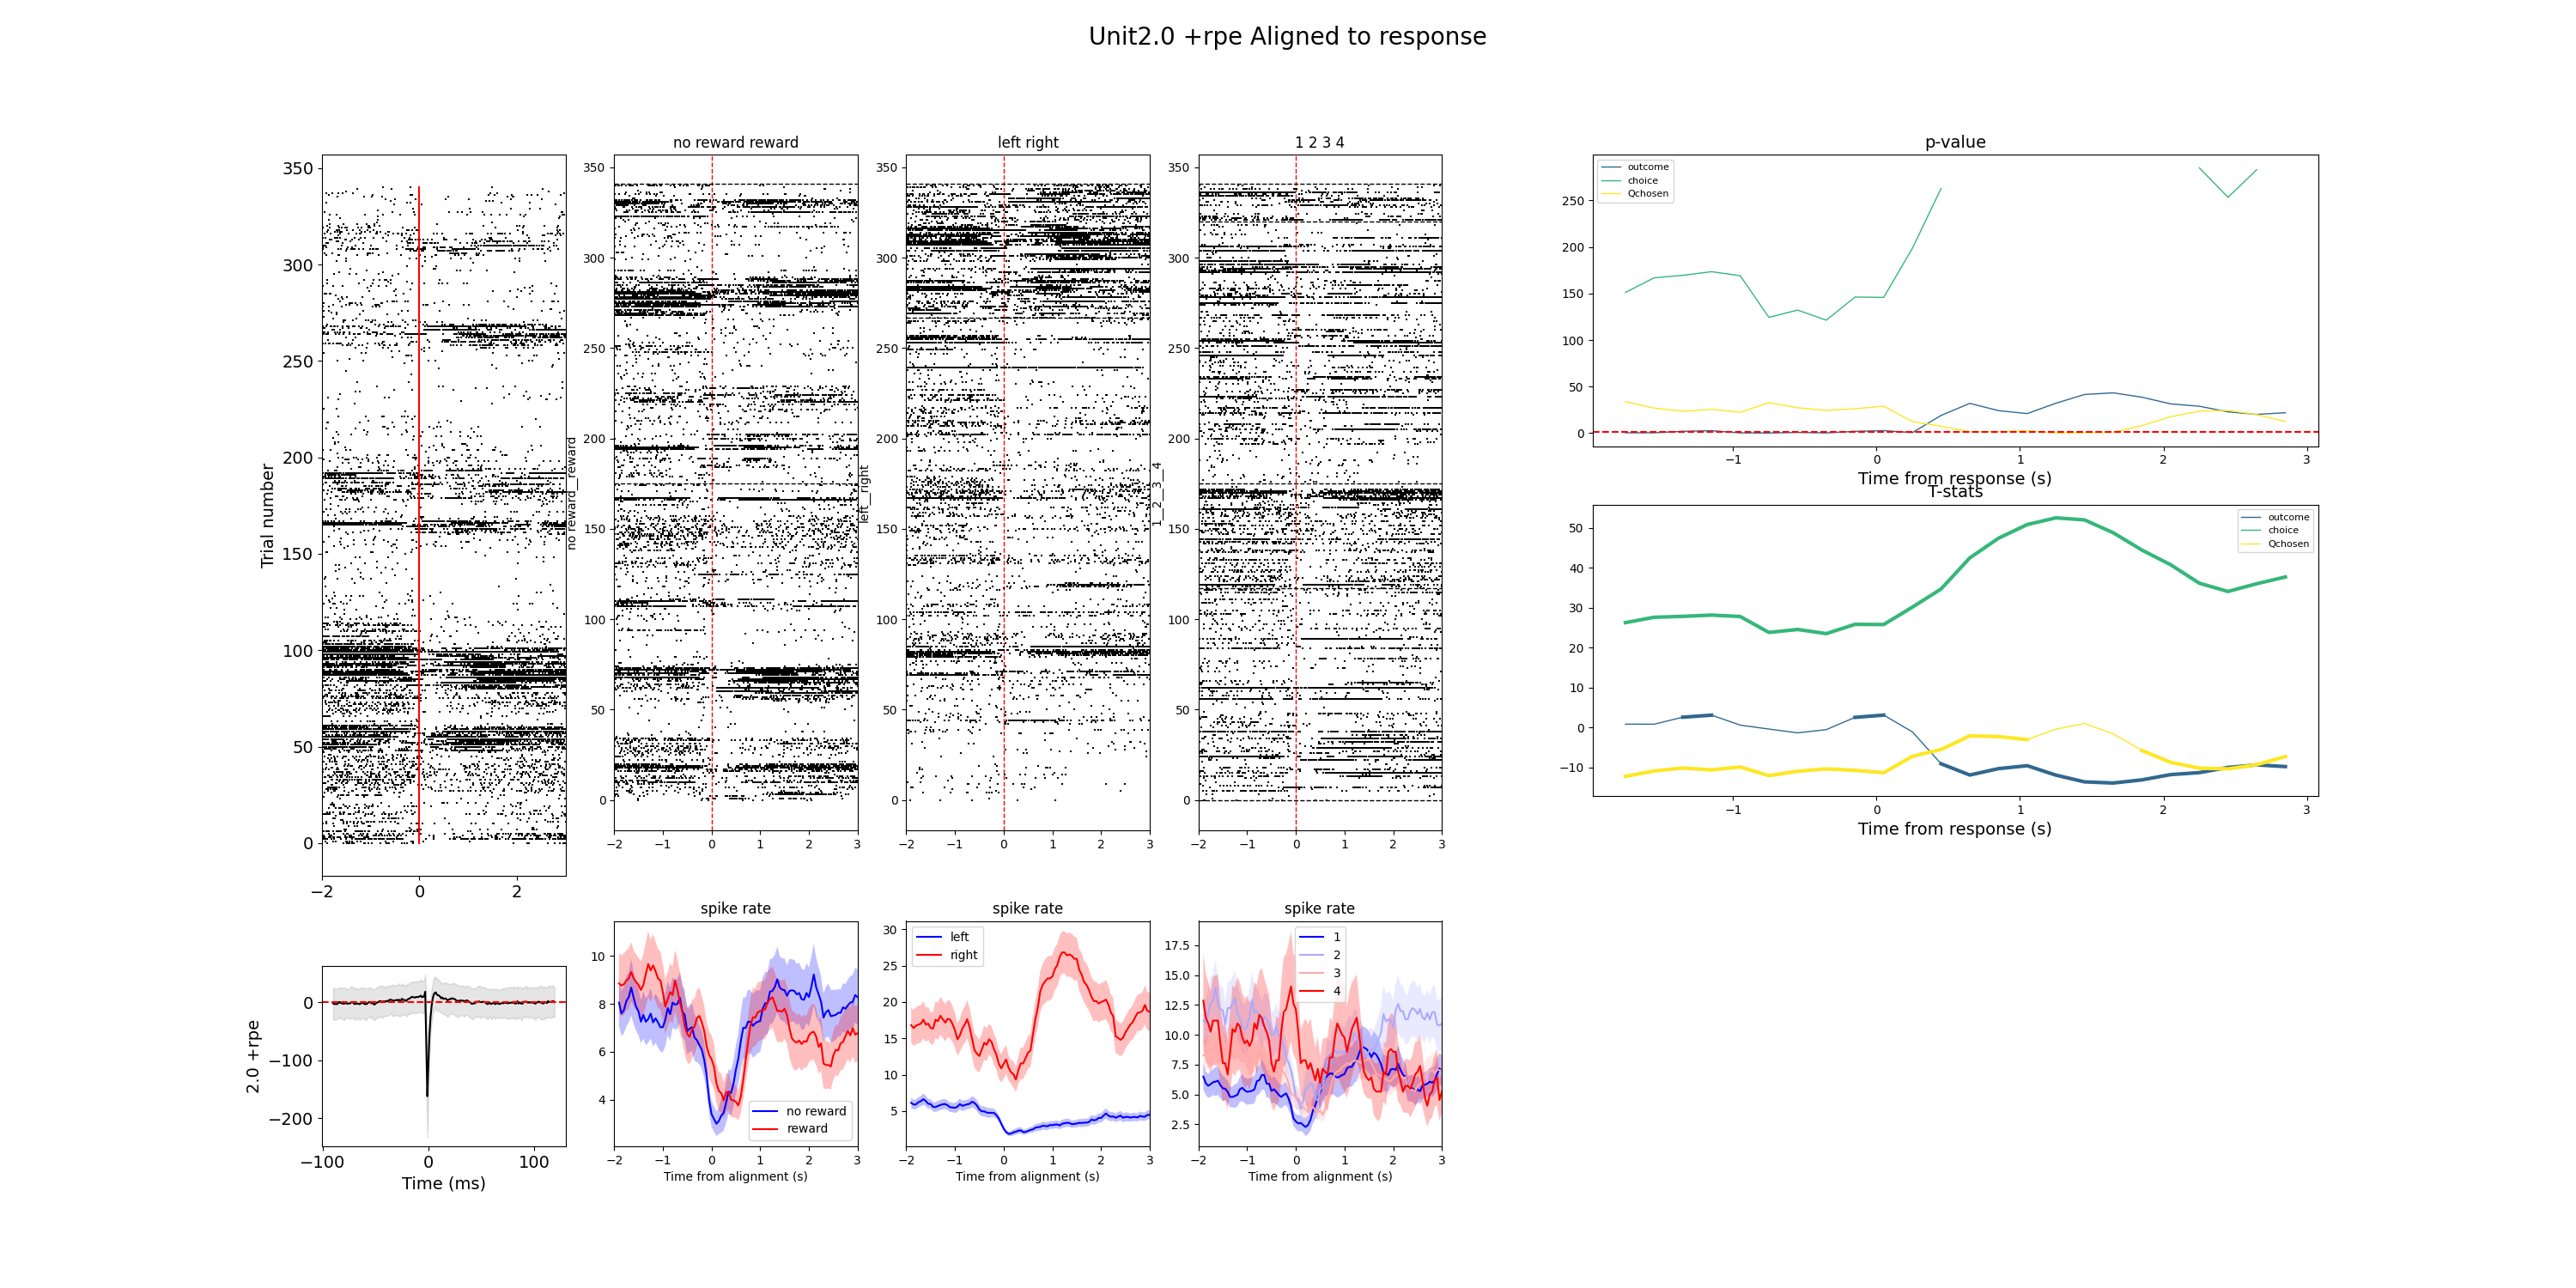

In [68]:
# plot all units
s = 6
fs = 14
fsLegend = 8
tb = -2
tf = 3
formula = 'spikes ~ 1 + outcome + choice + Qchosen'
cmap = plt.get_cmap('viridis')
unitIDs = unit_spikes['ks_unit_id'].values
for unitInd in range(len(unitIDs)):
    if unitInd%10==0:
        print('Neuron', unitIDs[unitInd])
    if pass_qc[unitInd]:
        label = f'{unitIDs[unitInd]} +rpe'
        plot_unit_new(unitInd, unit_label = label, align_time=alignTime, alignment=align_name, savepath=session_dir['ephys_fig_dir'])
# merge_pdfs(xarrayFolder, f'{sessionFolder}/{sessionID}combinedXarray.pdf')


In [ ]:
# to do: plot with resp vs no resp trials

In [ ]:
# to do: add causal filter

### Plot all opto tagged units

In [66]:
# behavior_716325_2024-05-31_10-31-14
opto_units = [13, 14, 15, 19, 50, 60, 79, 83, 87, 194, 197, 204, 209]
opto_units = [13, 14, 63, 87, 197, 209, 376, 377]
S1_units = [13, 63, 197]

In [71]:
s = 6
fs = 14
fsLegend = 8
tb = -2
tf = 3
formula = 'spikes ~ 1 + outcome + choice + Qchosen'
for opto_unit in opto_units:
    unit_ind = np.where(unit_spikes['ks_unit_id'].values == opto_unit)[0]

    if len(unit_ind)!=1:
        print(f'Unit {opto_unit} found {len(unit_ind)} times.')
        continue
    else:
        # unitInd = unitInd
        # unit_ids_curr = [str(unit) for unit in unit_ids_curr]
        # label = "-".join(unit_ids_curr)
        # label = label+'opto_goCue'+'_qcPass' +str(qcPass[unitInd])
        unit_ind = unit_ind[0]
        print('Neuron', opto_unit)

        label = f'{unitIDs[unit_ind]} +rpe pass_qc {pass_qc[unit_ind]}'
        plot_unit_new(unit_ind, unit_label = label, align_time=alignTime, alignment=align_name, savepath=os.path.join(session_dir['opto_fig_dir'], align_name))
        

Neuron 13
Neuron 14
Neuron 63
Neuron 87
Neuron 197
Neuron 209
Neuron 376
Neuron 377


No such comm: 663413b766c7461b9e9d74523579787f
No such comm: 663413b766c7461b9e9d74523579787f
No such comm: 663413b766c7461b9e9d74523579787f
No such comm: 663413b766c7461b9e9d74523579787f


In [76]:
tblTrials = nwb.trials.to_dataframe()
tblTrials['reward_delay']

id
0      0.2
1      0.2
2      0.2
3      0.2
4      0.2
      ... 
581    0.2
582    0.2
583    0.2
584    0.2
585    0.2
Name: reward_delay, Length: 586, dtype: float64